In this work I've tried to create my own Siamese Network and have trained on the MNIST dataset. Here is what I've learned during this project:

* When creating the dataset, don't forget to shuffle your data. It prevents the model to learn. Eventhough I've experienced this before, during this work I've mistakenly created the positive labels first and negative labels after initially (and of course realizing this mistake took a couple of hours of mine).

* Contrastive Loss function is available in tensorflow_addons but in large amount of iterations, it may result numerical instability. Defining manually can be more appropriate in this case. Here is an example from [Advanced Tensorflow Speacialization](https://www.deeplearning.ai/courses/tensorflow-advanced-techniques-specialization/):

```python
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss
```

I hope this project will be helpful for the reader.

# Imports and Loads

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
!pip install tensorflow_addons
import tensorflow_addons as tfa

import numpy as np
import random

import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
#download the dataset
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

#preprocess the dataset
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

Now we are ready to create our siamese dataset. To create the dataset;

**Positive Labelled Instances**
------------------------------

We need to pick a certain number of samples belonging to the same class and concatenate them.

**Negative Labelled Instances**
------------------------------

We need to do the opposite ie. pick a certain number of samples belonging to *different* classes and concatenate them.

The function below does exactly this.

In [3]:
def create_siamese_dataset(x_train,x_test,y_train,y_test,train_size = len(x_train),test_size = len(x_test)):
  """
  Creates siamese dataset by randomly picking the same and
  opposite classes

  Parameters
  ----------
  x_train,x_test: array like
    array form of an image

  y_train,y_test: array like
    labels of the image

  train_size: int
    the size of the training dataset

  test_size: int
    the size of the test dataset

  Returns
  -------
  train_pairs,test_pairs: array like
    paired image arrays

  train_labels,test_labels: array like
    binary array indicating whether two images belong to the same class or not
  """
  #initialize the datasets
  train_dataset = []
  test_dataset = []
  train_labels = []
  test_labels = []

  #create positive labels first
  for i in range(train_size):

    if i%2 == 0:


      #get a random class
      random_class = np.random.randint(low = y_train.min(),high = y_train.max())

      #get two random instances from randomly picked class from x_train
      train_random_instance_indexes = np.where(y_train == random_class)[0]
      train_random_instances = np.random.choice(train_random_instance_indexes,size = 2)
      training_pairs = x_train[train_random_instances]

      #append the piar instances to the final dataset
      train_dataset.append(training_pairs)
      train_labels.append(0)

    #create negative labels
    else:


      #get two random classes that are not equal
      random_class1 = np.random.randint(low = y_train.min(),high = y_train.max())
      candidates = [*range(y_train.min(),y_train.max())]
      candidates.remove(random_class1)
      random_class2 = np.random.choice(candidates)

      #pick two random instances from different classes
      train_random_instance_indexes1 = np.where(y_train == random_class1)[0]
      train_random_instance_indexes2 = np.where(y_train == random_class2)[0]
      train_random_instances1 = x_train[np.random.choice(train_random_instance_indexes1,size = 1)]
      train_random_instances2 = x_train[np.random.choice(train_random_instance_indexes2,size = 1)]

      #append the pairs to the dataset
      train_dataset.append([train_random_instances1[0],train_random_instances2[0]])
      train_labels.append(1)

  #apply the same procedure for test dataset
  for i in range(test_size):

    if i%2 == 0:

      #get a random class
      random_class = np.random.randint(low = y_test.min(),high = y_test.max())

      #get two random instances from randomly picked class from x_train
      test_random_instance_indexes = np.where(y_test == random_class)[0]
      test_random_instances = np.random.choice(test_random_instance_indexes,size = 2)
      test_pairs = x_test[test_random_instances]

      #append the pair instances to the final dataset
      test_dataset.append(test_pairs)
      test_labels.append(0)

    #create negative labels after
    else:
      #get two random classes that are not equal
      random_class1 = np.random.randint(low = y_test.min(),high = y_test.max())
      candidates = [*range(y_test.min(),y_test.max())]
      candidates.remove(random_class1)
      random_class2 = np.random.choice(candidates)

      #pick two random instances from different classes
      test_random_instance_indexes1 = np.where(y_test == random_class1)[0]
      test_random_instance_indexes2 = np.where(y_test == random_class2)[0]
      test_random_instances1 = np.random.choice(test_random_instance_indexes1,size = 1)
      test_random_instances2 = np.random.choice(test_random_instance_indexes2,size = 1)
      test_random_instances1 = x_test[np.random.choice(test_random_instance_indexes1,size = 1)]
      test_random_instances2 = x_test[np.random.choice(test_random_instance_indexes2,size = 1)]

      #append the pairs to the dataset
      test_dataset.append([test_random_instances1[0],test_random_instances2[0]])
      test_labels.append(1)

  #convert the datasets into numpy
  train_dataset = np.array(train_dataset).astype(np.float32)
  test_dataset = np.array(test_dataset).astype(np.float32)
  train_labels = np.array(train_labels).astype(np.float32)
  test_labels = np.array(test_labels).astype(np.float32)

  return train_dataset,train_labels,test_dataset,test_labels


In [4]:
train_dataset,train_labels,test_dataset,test_labels = create_siamese_dataset(x_train,x_test,y_train,y_test)

In [5]:
#check the process
train_dataset.shape,test_dataset.shape

((60000, 2, 28, 28), (10000, 2, 28, 28))

# Create the Siamese Model

Since the model is relatively complex structured, using Functional API is more beneficial for us.

In [6]:
def euclidean_distance(tensors):
  tensor1,tensor2 = tensors
  distance = tf.math.reduce_euclidean_norm((tensor1-tensor2),axis = -1,keepdims = True)
  return tf.maximum(distance,0.00000000001)

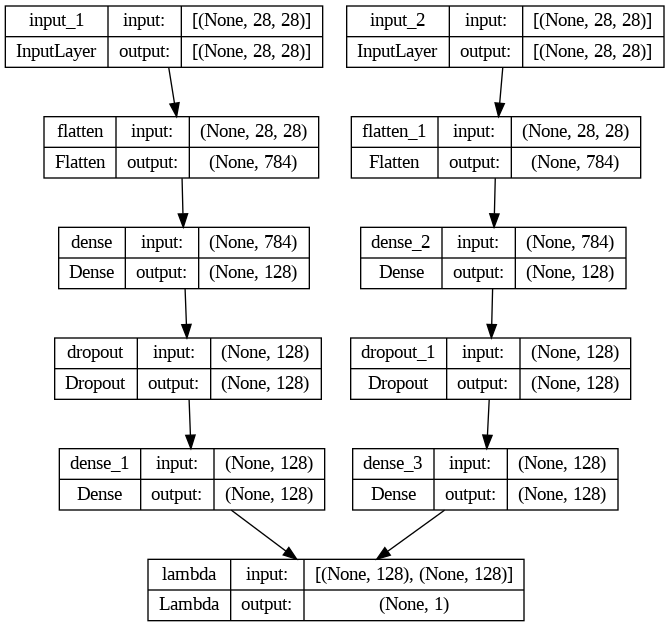

In [7]:
#define the inputs first
input1 = layers.Input(shape = (28,28),dtype = tf.float32)
input2 = layers.Input(shape = (28,28),dtype = tf.float32)

#put the inputs to a neural network to get the logits
flatten1 = layers.Flatten()(input1)
logit1_1 = layers.Dense(128,activation = 'relu')(flatten1)
dropout1 = layers.Dropout(0.2)(logit1_1)
logit1_2 = layers.Dense(128, activation = 'relu')(dropout1)

#do the same thing for input2
flatten2 = layers.Flatten()(input2)
logit2_1 = layers.Dense(128,activation = 'relu')(flatten2)
dropout2 = layers.Dropout(0.2)(logit2_1)
logit2_2 = layers.Dense(128, activation = 'relu')(dropout2)

#concatenate the logits and find the distance between two
outputs = layers.Lambda(euclidean_distance)([logit1_2,logit2_2])

#connect it to a fully connected layer
#x = layers.Dense(64,activation = 'relu')(euc_dist)
#outputs = layers.Dense(1,activation = 'sigmoid')(x) #since this is a binary classification task

model = tf.keras.Model(inputs = [input1,input2],
                       outputs = outputs, name = 'Siamese_model')

#plot the model
tf.keras.utils.plot_model(model,show_shapes = True)

In [8]:
#compile the model
model.compile(
    optimizer = 'adam',
    loss = tfa.losses.ContrastiveLoss(),

)

#fit the model
history = model.fit([train_dataset[:,0],train_dataset[:,1]],train_labels,
          validation_data = ([test_dataset[:,0],test_dataset[:,1]],test_labels),
          epochs = 5,
          batch_size = 32)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2433 - val_loss: 0.1910
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1899 - val_loss: 0.1783
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1801 - val_loss: 0.1791
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1759 - val_loss: 0.1747
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1741 - val_loss: 0.1746


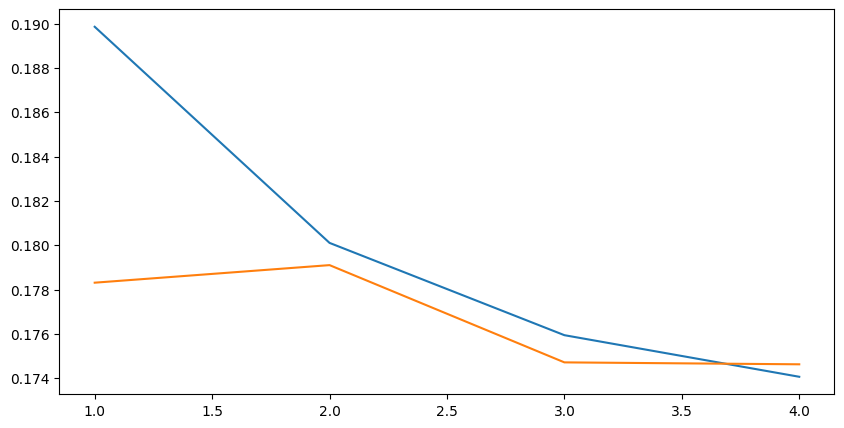

In [9]:
plt.figure(figsize = (10,5))
plt.plot(history.epoch[1:],history.history['loss'][1:])
plt.plot(history.epoch[1:],history.history['val_loss'][1:])

In [10]:
model_train_predictions_logits = model.predict([train_dataset[:,0],train_dataset[:,1]]).ravel()
model_train_predictions = [1 if logit < 0.5 else 0 for logit in model_train_predictions_logits]

model_test_predictions_logits = model.predict([test_dataset[:,0],test_dataset[:,1]]).ravel()
model_test_predictions = [1 if logit < 0.5 else 0 for logit in model_test_predictions_logits]

#compute accuracy score
training_accuracy = tf.keras.metrics.binary_accuracy(y_true = train_labels,y_pred = model_train_predictions).numpy()
test_accuracy = tf.keras.metrics.binary_accuracy(y_true = test_labels,y_pred = model_test_predictions).numpy()

training_accuracy,test_accuracy

313/313 [==============================] - 1s 3ms/step


(0.77396667, 0.755)